In [91]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize
import torchvision
import torchvision.transforms as transforms
import pickle
import numpy as np
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

# first
# b = torch.Tensor([[[1,2,3], [4,5,6]], [[1,6,3], [9,7,6]]])
# print (b.shape)

# print (b)

# c = normalize(b, dim=2)

# print (c)

In [ ]:
### label align

In [ ]:
'''
正类： 疾病(<0.5) 0 False

负类： 健康人群(>0.5) 1 False


'''



a = torch.tensor([0.4791, 0.3276, 0.4216, 0.5010, 0.5999, 0.5712, 0.2843, 0.3870, 0.3538,
        0.3936, 0.4180, 0.4626, 0.4823, 0.3987, 0.4032, 0.4724, 0.5182, 0.3562,
        0.4056, 0.4954, 0.5857, 0.5914, 0.4393, 0.4548, 0.4764, 0.3856, 0.4595,
        0.4386, 0.4567, 0.4145, 0.4293, 0.4282, 0.3331, 0.3347, 0.4714, 0.4566,
        0.4068, 0.5098, 0.4457, 0.4518, 0.4451, 0.4042, 0.4178, 0.3525, 0.4786,
        0.5250, 0.5098, 0.4142, 0.5047, 0.3729, 0.4594, 0.3874, 0.4116, 0.4010,
        0.4587, 0.3962, 0.4711, 0.4286, 0.4572, 0.4687, 0.4272, 0.4198, 0.4558,
        0.4267])

print (a)

print (a.shape)

flag  = a>0.5

print (flag)

print (True == 1)
print (False == 0)

b = torch.where(flag, 1, 0)

print (b)

print (b.dtype)

print (1.0==1)


ba  = b[0:5]

print (ba)
print (ba.dtype)

bc = torch.tensor([.0, .0, .0, 1, 1])
print (bc.dtype)
print (bc)
correct = torch.eq(ba, bc).sum().item()

print (correct)

# y = torch.randn(2,3,4)
# print (y.shape)
# y = y.transpose(0,1)
# print (y.shape)

# y = y.reshape(y.size(0),-1)

# print (y.shape)


In [ ]:
#### max-min scaler normalization per point

In [95]:
def maxmin1(x):
 
    max_value = x.max().item()
    print ('1:', max_value)
    min_value = x.min().item()  
    print ('2:', min_value)
    x_normalized = (x - min_value) / (max_value - min_value)
     
    return x_normalized

# x = torch.tensor([[[1, 2], [4, 5], [7, 8]], [[3, 3], [6, 1], [9, 10]]])

# print (x.shape)

# x_normalized = maxmin1(x)

# print (x_normalized)

# x_normalized = (x - mean(x)) / std(x)

In [96]:
def partition(RG_GRFf_file_path, RG_GRFl_file_path, abn_ratio):

    with open(RG_GRFf_file_path, 'rb') as file:
        GRFf = pickle.load(file).astype(np.float32)[:,:1000,:]
    file.close()

    with open(RG_GRFl_file_path, 'rb') as file:
        GRFl = pickle.load(file).astype(np.float32)
    file.close()
    
    # stat indice for 0(abnormal)/1(healthy)
    GRFl_0_indice = np.where(GRFl==0)
    GRFl_1_indice = np.where(GRFl==1)
    
    # print ('6:', GRFl_0_indice)
    # print ('7:', GRFl_1_indice)
    
    # select the corresponding features for indice
    GRFl_features_0 = GRFf[list(GRFl_0_indice[0])]
    GRFl_features_1 = GRFf[list(GRFl_1_indice[0])]
    
    # select the corresponding features for indice
    GRFl_0 = GRFl[list(GRFl_0_indice[0])]
    GRFl_1 = GRFl[list(GRFl_1_indice[0])]

    # print (GRFl_features_0.shape)
    
    # print (GRFl_features_1.shape)
    
    # 67977 abnoraml / 16574 healthy, 因此至少
    # print (round(len(GRFl_0)/len(GRFl_1),3))
    
    # print (GRFl_0.shape)
    
    # print (GRFl_1.shape)

    # 训练样本
    #### Portation of  0(abnormal)
    total_sample_size = GRFl_features_0.shape[0]
    total_sample_range = list(np.arange(0, total_sample_size))
    train_sample_size = int(GRFl_features_0.shape[0] * abn_ratio)
    # 训练
    train_indices = np.random.choice(GRFl_features_0.shape[0], size = train_sample_size, replace=False)
    # print ('1:', indices)
    # print ('2:', type(indices))
    # print ('3:', indices.shape)
    GRFl_features_0_portion_train = GRFl_features_0[train_indices]
    GRFl_0_portion_train = GRFl_0[train_indices]
    # print ('4:', GRFl_features_0_portion)
    # print ('5:', type(GRFl_features_0_portion))
    # print ('6:', GRFl_features_0_portion.shape)
    # print ('44:', GRFl_0_portion)
    # print ('7:', type(GRFl_0_portion))
    # print ('8:', GRFl_0_portion.shape)    
    #### Concatenate of  0(abnormal) + 1(healthy)
    ## 3398 + 16574 = 19972
    GRFf_train = np.concatenate((GRFl_features_0_portion_train, GRFl_features_1),axis = 0)
    GRFl_train = np.concatenate((GRFl_0_portion_train, GRFl_1),axis = 0)
    # print ('9:', type(GRFf)) 
    # print ('10:', GRFf.shape) 
    # print ('11:', type(GRFl)) 
    # print ('12:', GRFl.shape)
    
    # 测试样本
    test_indices = []
    for e in total_sample_range:
        if e not in train_indices:
            # test_indices.append(np.where(total_sample_range==e)[0][0])
            test_indices.append(e)
            
    ##
    test_indices = np.array(test_indices)
    GRFl_features_0_portion_test = GRFl_features_0[test_indices]
    GRFl_0_portion_test = GRFl_0[test_indices]
    ##
    GRFf_test = np.concatenate((GRFl_features_0_portion_test, GRFl_features_1), axis = 0)
    GRFl_test = np.concatenate((GRFl_0_portion_test, GRFl_1), axis = 0)

    ####
    print ('13:', GRFf_train.shape)
    print ('14:', GRFl_train.shape)
    print ('15:', GRFf_test.shape)
    print ('16:', GRFl_test.shape)

    return GRFf_train, GRFl_train, GRFf_test, GRFl_test

In [97]:
def balance_01(X, Y):
    GRFf = X
    GRFl = Y
    # 使用SMOTE进行过采样时正样本和负样本要放在一起，生成比例1：1
    smo = SMOTE(n_jobs=-1)
    # 这里必须是fit_resample()，有些版本是fit_sample()无法运行
    #### reshape, 用KNN来插值维度必须是1D
    GRFf_1d = GRFf.reshape(GRFf.shape[0], -1)
    # print ('test1:', GRFf.shape)
    # 特征维度
    GRFf_1d_fnum = GRFf.shape[1]
    
    # print ('1:', GRFf_1d.shape)
    GRFf_re, GRFl_re = smo.fit_resample(GRFf_1d, GRFl)
    
    # print ('2:', GRFf_re.shape)
    # print ('3:', GRFl_re.shape)
    # 样本
    GRFf_re = GRFf_re.reshape(GRFf_re.shape[0], GRFf_1d_fnum, -1)
    #
    # print ('4:', GRFf_re.shape)
    
    
    #### test the distribution proportion
    #
    #
    GRFl_re_0_indice = np.where(GRFl_re==0)
    GRFl_re_1_indice = np.where(GRFl_re==1)
    
    #### 1:1，少数类样本0(疾病人群)数量增加为16574(0.05)
    # print ('5:', len(list(GRFl_re_0_indice[0]))) 
    # print ('6:', len(list(GRFl_re_1_indice[0]))) 
    # print ('7:', GRFf_re)
    #
    #
    #
    print ('17:', len(list(GRFl_re_0_indice[0])))
    print ('18:', len(list(GRFl_re_1_indice[0])))    
    
    return GRFf_re, GRFl_re

In [98]:
# ---------------1、load---------------
RG_GRFf_file_path = 'nihgrff.pkl'
RG_GRFl_file_path = 'nihgrfl.pkl'


# part ratio，这里健康样本是陪衬，一直要加上
# abn_ratio = 0.3 # 30%训练
# abn_ratio = 0.2 # 20%训练#
abn_ratio = 0.1 # 10%
# abn_ratio = 0.05 # 5%
# abn_ratio = 0.01


# 按比例切分样本，但目前是固定10%:90%, 20%:80%, 30%:70%, 但目前的10% 20% 30%必须变起来写成随机化的(sampler???)
GRFf_train_part, GRFl_train_part, GRFf_val_part, GRFl_val_part  =  partition(RG_GRFf_file_path, RG_GRFl_file_path, abn_ratio)
# 平衡训练集样本量，正负样本数为1:1
GRFf_train_ba, GRFl_train_ba = balance_01(GRFf_train_part, GRFl_train_part)
# 平衡训练集样本量，正负样本数为1:1
GRFf_val_ba, GRFl_val_ba = balance_01(GRFf_val_part, GRFl_val_part)

# ------------------------ 2、normlization max-min scaler------------------------
GRFf_train = torch.from_numpy(GRFf_train_ba)
GRFf_train = maxmin1(GRFf_train)

GRFf_val = torch.from_numpy(GRFf_val_ba)
GRFf_val = maxmin1(GRFf_val)

#
GRFl_train = torch.from_numpy(GRFl_train_ba)
GRFl_val = torch.from_numpy(GRFl_val_ba)

# ------------------------ 3、Tensor Dataset------------------------
train_set = TensorDataset(GRFf_train, GRFl_train)
val_set = TensorDataset(GRFf_val, GRFl_val)


13: (75, 1000, 19)
14: (75,)
15: (163, 1000, 19)
16: (163,)
17: 64
18: 64
17: 99
18: 99
1: 1589.93994140625
2: 0.0
1: 1589.93994140625
2: 0.0


In [99]:
# -----------------4、dataloader------------------------
abn_ratio = 0.01 # 1% 
val_percent = 0.3
train_batch_size = 32
test_batch_size = 48
workers  = 3
pin_memory = True

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = train_batch_size,
    shuffle = True,
    num_workers = workers,
    pin_memory = pin_memory,
    sampler = None
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size = test_batch_size,
    shuffle = False,
    num_workers = workers,
    pin_memory = pin_memory
)

print ('11:', train_loader)
print ('12:', val_loader)

print ('13:', len(train_loader))
print ('14:', len(val_loader))

11: <torch.utils.data.dataloader.DataLoader object at 0x0000017189DB7C50>
12: <torch.utils.data.dataloader.DataLoader object at 0x0000017189DD1BD0>
13: 4
14: 5


In [ ]:
### 3layer CNN

In [100]:
# 卷积组: Conv2d+BN+ReLU
class BasicConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(BasicConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = BasicConv1d(19, 128, 3)
        self.conv2 = BasicConv1d(128, 64, 3)
        self.conv3 = BasicConv1d(64, 32, 3)
        self.maxp = nn.MaxPool1d(kernel_size=2, stride=1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(31776, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.conv1(torch.transpose(x,1,2))
        # print ('1:', x.shape)
        x = self.conv2(x)
        # print ('2:', x.shape)
        x = self.conv3(x)
        # print ('3:', x.shape)
        x = self.maxp(x)
        # print ('4:', x.shape)
        x = self.dropout(x)
        # print ('5:', x.shape)
        x = x.reshape(x.size(0),-1)
        # print ('5:', x.shape)
        x = self.fc(x)
        # print ('6:', x.shape)
        X = self.sigmoid(x).squeeze()
        # print ('7:', X.shape)
        return X


In [ ]:
### Setting

In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ConvNet().to(device)
print (net)
net = net.to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0001)
# optimizer = optim.Adam(net.parameters(), lr=0.001)
#
optimizer = optim.Adam(net.parameters(), lr=0.01)
# optimizer = optim.Adam(net.parameters(), lr=0.1)


# 0.1 reduce / 10 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

###
# epochs = 100
epochs = 1

# acc

def accuracy_fn(y_true, y_pred):
    print ('y_pred1:', y_pred)
    y_pred = y_pred>0.5
    print ('y_pred2:', y_pred)
    y_pred = torch.where(y_pred, 1, 0)
    print ('y_pred3:', y_pred)
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100
    return acc

# confusion matrix
# 混淆矩阵计算
def calculate_performance_metrics(y_true, y_pred, labels):

    # 预测矩阵转换0 1矩阵
    y_pred = y_pred>0.5
    y_pred = torch.where(y_pred,1,0)

    # print ('0:', y_pred)
    # print ('00:', y_true)
    # print ('0_:', y_pred.shape)
    # print ('00_:', y_true.shape)
    

    # 再转换为numpy类型
    # y_pred = y_pred.detach().numpy()
    y_pred = y_pred.cpu().numpy()
    
    # y_true = y_true.detach().numpy()
    y_true = y_true.cpu().numpy()

    # print ('11:', type(y_pred))
    # print ('22:', type(y_true))
    # print ('33:', y_pred.shape)
    # print ('44:', y_true.shape)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    # 混淆矩阵画图
#     fx = plot_cm(cm)
    
    # 计算精度
    precision = precision_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算召回率
    recall = recall_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算F1分数
    f1 = f1_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算平衡F1分数
    # 这里假设有一个函数balanced_accuracy_score来计算平衡F1分数
    balanced_f1 = balanced_accuracy_score(y_true, y_pred)
    
    return cm, precision, recall, f1, balanced_f1

ConvNet(
  (conv1): BasicConv1d(
    (conv): Conv1d(19, 128, kernel_size=(3,), stride=(1,))
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv2): BasicConv1d(
    (conv): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv3): BasicConv1d(
    (conv): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxp): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=31776, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
### Timing

In [102]:
from timeit import default_timer as timer
def print_train_time(start:float,
                     end:float,
                     device:torch.device =None):
    total_time = end - start
    print(f"Train time on {device}:{total_time:.3f} seconds")
    return total_time
 
start_time = timer()
# 模型的运算在此处进行……
end_time = timer()
print_train_time(start = start_time,end=end_time,device="cpu")
 
# 运行结果
# Train time on cpu:0.000 seconds
# 3.819999983534217e-05

Train time on cpu:0.000 seconds


2.3899832740426064e-05

In [ ]:
### Training

In [103]:
from tqdm import *
torch.manual_seed(42)
train_time_start_on_cpu = timer() 
 
##############################################
for epoch in tqdm(range(epochs)):  
    print(f"Epoch:{epoch}\n------")
    train_loss = 0 
    for batch,(X,y) in enumerate(train_loader): 
        # 
        X, y = X.to(device), y.to(device)

        net.train() 
        y_pred = net(X)
        #
        # print ('1:', y_pred)
        # print ('2:', y_pred.shape)
        # print ('3:', y)
        # print ('4:', y.shape)        
 
        loss = criterion(y_pred,y)
        # print ('train_loss:', loss)
        train_loss+=loss
        
        optimizer.zero_grad()
 
        loss.backward()
 
        optimizer.step()
        scheduler.step()
 
        # if batch % 400 == 0:
        if batch % 400 == 0:
            print(f"Look at {batch * len(X)}/{len(train_loader.dataset)} samples.")
            # break
 
    train_loss /= len(train_loader)
    

    ###################val/per epoch###########################
    val_loss, val_acc = 0, 0 
    net.eval() 
    precision_t = 0
    recall_t = 0
    f1_t = 0
    balanced_f1_t = 0
    cm_t = np.zeros((2,2))
    
    with torch.inference_mode():
        for x_val, y_val in val_loader:
            #
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = net(x_val) 
            val_loss+=criterion(val_pred, y_val)
            # print ('test_loss:', loss)
            # print ('val_pred:', val_pred)
            # print ('y_val:', y_val)
            # print ('val_pred:', val_pred.shape)
            # print ('y_val:', val_pred.shape)
            val_acc += accuracy_fn(y_true = y_val, y_pred = val_pred)
            cm, precision, recall, f1, balanced_f1 = calculate_performance_metrics(y_true = y_val, y_pred = val_pred, labels=[0,1])
            
            precision_t += precision
            recall_t += recall
            f1_t += f1
            balanced_f1_t += balanced_f1
            cm_t += cm
            
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        precision_t /=len(val_loader)
        recall_t /=len(val_loader)
        f1_t /=len(val_loader)
        balanced_f1_t /=len(val_loader)
        
        
    
    print(f"\nTrain loss:{train_loss:.4f} | Test loss:{val_loss:.4f}, Test acc:{val_acc:.4f}")
    
    print ('avg-precision:', precision_t)
    print ('avg-recall:', recall_t)
    print ('avg-f1:', f1_t)
    print ('avg-balanced_f1:', balanced_f1_t)
    print ('last-cm:', cm_t)


# 计算训练时间
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(net.parameters()).device))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Epoch:0
------
Look at 0/128 samples.
y_pred1: tensor([0.8804, 0.9999, 1.0000, 0.8370, 0.9988, 0.9999, 0.9492, 0.9969, 0.9366,
        1.0000, 1.0000, 0.8766, 0.8819, 0.7092, 0.9920, 0.9952, 0.9998, 0.9824,
        0.9584, 0.9591, 0.9958, 0.9209, 0.9638, 0.2854, 0.2815, 0.2854, 0.9511,
        0.8760, 0.8371, 0.9341, 0.9433, 0.9999, 0.9064, 0.9978, 0.9950, 0.9925,
        0.9999, 0.9996, 0.9997, 0.9337, 0.9650, 0.9062, 0.9998, 0.9969, 0.9994,
        0.9778, 0.9684, 0.9992], device='cuda:0')
y_pred2: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
y_pred3: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
    

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Train loss:16.1098 | Test loss:2.3031, Test acc:57.9167
avg-precision: 0.49347826086956526
avg-recall: 0.29555555555555557
avg-f1: 0.30877569489334195
avg-balanced_f1: 0.4955555555555556
last-cm: [[ 11. 100.]
 [ 13.  92.]]
Train time on cuda:0:4.919 seconds


cm_total: [[ 11. 100.]
 [ 13.  92.]]
1: [ 11. 100.]
2: 111.0
conf_matrix: [array([0.0990991, 0.9009009]), array([0.12380952, 0.87619048])]


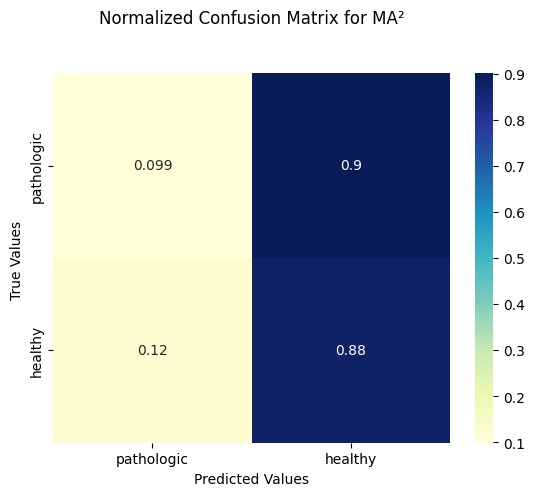

<function matplotlib.pyplot.cla() -> 'None'>

In [104]:
'''
如图，可发现，用Seaborn画出来的热力图中，只有第一行单元格有数字，其他行单元格均不显示数字。

二、找出原因

首先排除了参数使用错误这一原因，因为在sns.heatmap函数中，我的annot这一参数使用的是"True"，即单元格中显示数值。

sns.heatmap(wine_data_heat.corr() , annot = True,
            xticklabels=x,
            yticklabels=y)
后面在网上找了一些资料，发现是matplotlib版本过高的原因：matplotlib一直在更新，我现在使用是的matplotlib 3.8.2，而seaborn最新版本是在2023年4月更新的。

三、解决问题

我尝试将matplotlib的版本降低为3.7.3。

在cmd中执行命令行，查看当前版本：                      
'''


import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random

# conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(7)))
# conf_matrix = [conf_matrix[i]*1.0/sum(conf_matrix[i]) for i in range(len(conf_matrix))]

# Using Seaborn heatmap to create the plot
# fx = sebrn.heatmap(conf_matrix, annot=True, cmap="turbo")

# # labels the title and x, y axis of plot
# fx.set_title("Plotting Confusion Matrix using Seaborn\n\n")
# fx.set_xlabel("Predicted Values")
# fx.set_ylabel("Actual Values ")

# # labels the boxes
# fx.xaxis.set_ticklabels(['suprised', 'afraid', 'disgust', 'happy', 'sad', 'angry', 'neutral'])
# fx.yaxis.set_ticklabels(['suprised', 'afraid', 'disgust', 'happy', 'sad', 'angry', 'neutral'])

# atlas.show()

#### 混淆矩阵画图
print ('cm_total:', cm_t)

print ('1:', cm_t[0])
print ('2:', sum(cm_t[0]))

conf_matrix = [cm_t[i]*1.0/sum(cm_t[i]) for i in range(len(cm_t))]

# conf_matrix = cm_total

print ('conf_matrix:', conf_matrix)
fx = sebrn.heatmap(conf_matrix, annot=True, cmap="YlGnBu")
# fx = sebrn.heatmap(cm_t, annot=True, cmap="YlGnBu")

# sn.heatmap(cm_total,annot=True)

fx.set_title("Normalized Confusion Matrix for MA²\n\n")
# fx.set_title("Confusion Matrix for MA²\n\n")
#
fx.set_xlabel("Predicted Values")
fx.set_ylabel("True Values ")

fx.xaxis.set_ticklabels(['pathologic', 'healthy',])
fx.yaxis.set_ticklabels(['pathologic', 'healthy',])
plt.savefig("MA2_con1", dpi=330)
plt.show()

plt.cla



In [ ]:
[[]]

In [ ]:
[[]]

In [ ]:
[[]]

In [ ]:
[[]]

In [ ]:
[[]]

In [ ]:
#### LSTM

In [105]:

# Define LSTM Neural Networks
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
 
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)  # utilize the LSTM model in torch.nn
        self.linear = nn.Linear(hidden_size, output_size) # 全连接层
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, _x):
        # transpose1
        # _x = _x.transpose(0,2)  # _x is input, size (seq_len, input_size, batch)
        _x = _x.transpose(0,1)  # _x is input, size (seq_len, batch, input_size)
        # print ('0:', _x.shape)
        
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        # transpose2
        # x = x.transpose(0,1) #  size (batch, seq_len , hidden_size)
        # reshape
        # x = x.reshape(x.size(0), -1)
        # print ('1:', x.shape)
        x = self.linear(x)
        X = x[-1, :, :]
        # print ('2:', X.shape)        
        X = self.sigmoid(X).squeeze()

        return X


In [ ]:
### Setting

In [ ]:
### Setting

In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INPUT_FEATURES_NUM = 19
HIDDEN_FEATURES_NUM = 128
OUTPUT_FEATURES_NUM = 1
LAYERS_NUM = 3
net2 = LstmRNN(input_size = INPUT_FEATURES_NUM, hidden_size = HIDDEN_FEATURES_NUM, output_size = OUTPUT_FEATURES_NUM, num_layers = LAYERS_NUM)  
print (net2)
net2 = net2.to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0001)
# optimizer = optim.Adam(net.parameters(), lr=0.001)
#
optimizer = optim.Adam(net2.parameters(), lr=0.0001)
# optimizer = optim.Adam(net.parameters(), lr=0.1)


# 0.1 reduce / 10 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

###
# epochs = 100
epochs = 1

# acc

def accuracy_fn(y_true, y_pred):
    y_pred = y_pred>0.5
    y_pred = torch.where(y_pred, 1, 0)
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100
    return acc



# confusion matrix
# 混淆矩阵计算
def calculate_performance_metrics(y_true, y_pred, labels):

    # 预测矩阵转换0 1矩阵
    y_pred = y_pred>0.5
    y_pred = torch.where(y_pred,1,0)

    # print ('0:', y_pred)
    # print ('00:', y_true)
    # print ('0_:', y_pred.shape)
    # print ('00_:', y_true.shape)
    

    # 再转换为numpy类型
    # y_pred = y_pred.detach().numpy()
    y_pred = y_pred.cpu().numpy()
    
    # y_true = y_true.detach().numpy()
    y_true = y_true.cpu().numpy()

    # print ('11:', type(y_pred))
    # print ('22:', type(y_true))
    # print ('33:', y_pred.shape)
    # print ('44:', y_true.shape)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    # 混淆矩阵画图
#     fx = plot_cm(cm)
    
    # 计算精度
    precision = precision_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算召回率
    recall = recall_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算F1分数
    f1 = f1_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算平衡F1分数
    # 这里假设有一个函数balanced_accuracy_score来计算平衡F1分数
    balanced_f1 = balanced_accuracy_score(y_true, y_pred)
    
    return cm, precision, recall, f1, balanced_f1

LstmRNN(
  (lstm): LSTM(19, 128, num_layers=3)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
### Training

In [108]:
from tqdm import *
torch.manual_seed(42)
train_time_start_on_cpu = timer() 
 
 
##############################################
for epoch in tqdm(range(epochs)):  
    print(f"Epoch:{epoch}\n------")
    train_loss = 0 
    for batch,(X,y) in enumerate(train_loader): 
        #
        X, y = X.to(device), y.to(device)

        net2.train() 
        y_pred = net2(X)
        #
        # print ('1:', y_pred)
        # print ('2:', y_pred.shape)
        # print ('3:', y)
        # print ('4:', y.shape)        
 
        loss = criterion(y_pred,y)
        # print ('train_loss:', loss)
        train_loss+=loss
        
        optimizer.zero_grad()
 
        loss.backward()
 
        optimizer.step()
        scheduler.step()
 
        # if batch % 400 == 0:
        if batch % 400 == 0:
            print(f"Look at {batch * len(X)}/{len(train_loader.dataset)} samples.")
            # break
 
    train_loss /= len(train_loader)
    

    
###################val/per epoch###########################
    val_loss, val_acc = 0, 0
    precision_t = 0
    recall_t = 0
    f1_t = 0
    balanced_f1_t = 0
    cm_t = np.zeros((2,2))    
    net2.eval() 
    
    with torch.inference_mode():
        for x_val, y_val in val_loader:
            #
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = net2(x_val) 
            val_loss+=criterion(val_pred, y_val)
            # print ('test_loss:', loss)
            # print ('val_pred:', val_pred)
            # print ('y_val:', y_val)
            # print ('val_pred:', val_pred.shape)
            # print ('y_val:', val_pred.shape)
            val_acc += accuracy_fn(y_true = y_val, y_pred = val_pred)
            cm, precision, recall, f1, balanced_f1 = calculate_performance_metrics(y_true = y_val, y_pred = val_pred, labels=[0,1])  

            precision_t += precision
            recall_t += recall
            f1_t += f1
            balanced_f1_t += balanced_f1
            cm_t += cm

        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        precision_t /=len(val_loader)
        recall_t /=len(val_loader)
        f1_t /=len(val_loader)
        balanced_f1_t /=len(val_loader)

    
    print(f"\nTrain loss:{train_loss:.4f} | Test loss:{val_loss:.4f}, Test acc:{val_acc:.4f}")
    
    print ('avg-precision:', precision_t)
    print ('avg-recall:', recall_t)
    print ('avg-f1:', f1_t)
    print ('avg-balanced_f1:', balanced_f1_t)
    print ('last-cm:', cm_t)
    
 # 计算训练时间
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(net2.parameters()).device))



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Epoch:0
------
Look at 0/128 samples.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Train loss:0.6934 | Test loss:0.6953, Test acc:41.2500
avg-precision: 0.20625
avg-recall: 0.3
avg-f1: 0.21176470588235294
avg-balanced_f1: 0.5
last-cm: [[ 99.  96.]
 [195.  96.]]
Train time on cuda:0:5.193 seconds


cm_total: [[ 99.  96.]
 [195.  96.]]
1: [99. 96.]
2: 195.0
conf_matrix: [array([0.50769231, 0.49230769]), array([0.67010309, 0.32989691])]


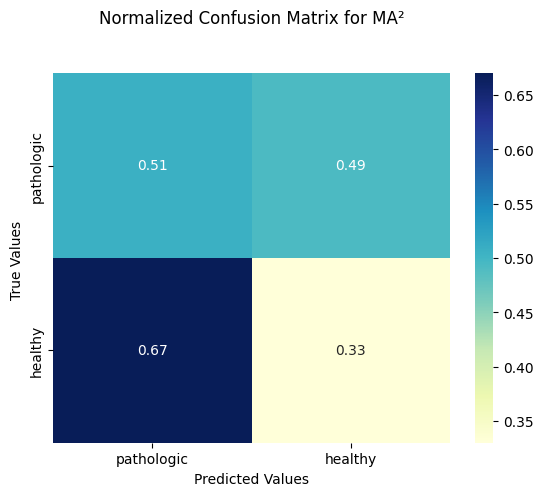

<function matplotlib.pyplot.cla() -> 'None'>

In [109]:
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random

# conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(7)))
# conf_matrix = [conf_matrix[i]*1.0/sum(conf_matrix[i]) for i in range(len(conf_matrix))]

# Using Seaborn heatmap to create the plot
# fx = sebrn.heatmap(conf_matrix, annot=True, cmap="turbo")

# # labels the title and x, y axis of plot
# fx.set_title("Plotting Confusion Matrix using Seaborn\n\n")
# fx.set_xlabel("Predicted Values")
# fx.set_ylabel("Actual Values ")

# # labels the boxes
# fx.xaxis.set_ticklabels(['suprised', 'afraid', 'disgust', 'happy', 'sad', 'angry', 'neutral'])
# fx.yaxis.set_ticklabels(['suprised', 'afraid', 'disgust', 'happy', 'sad', 'angry', 'neutral'])

# atlas.show()

#### 混淆矩阵画图
print ('cm_total:', cm_t)

print ('1:', cm_t[0])
print ('2:', sum(cm_t[0]))

conf_matrix = [cm_t[i]*1.0/sum(cm_t[i]) for i in range(len(cm_t))]

# conf_matrix = cm_total

print ('conf_matrix:', conf_matrix)
fx = sebrn.heatmap(conf_matrix, annot=True, cmap="YlGnBu")
# fx = sebrn.heatmap(cm_t, annot=True, cmap="YlGnBu")

# sn.heatmap(cm_total,annot=True)

fx.set_title("Normalized Confusion Matrix for MA²\n\n")
# fx.set_title("Confusion Matrix for MA²\n\n")
#
fx.set_xlabel("Predicted Values")
fx.set_ylabel("True Values ")

fx.xaxis.set_ticklabels(['pathologic', 'healthy',])
fx.yaxis.set_ticklabels(['pathologic', 'healthy',])
plt.savefig("MA2_con2", dpi=330)
plt.show()

plt.cla

In [ ]:
[[]]

In [ ]:
[[]]

In [ ]:
[[]]

In [ ]:
#### 1DCNN + LSTM

In [110]:
class BasicConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(BasicConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x



class CNN3LSTM(nn.Module):
    def __init__(self, lstm_input_size, lstm_hidden_size=1, lstm_output_size=1, lstm_num_layers=1):
        super(CNN3LSTM, self).__init__()
        self.conv1 = BasicConv1d(19, 512, 1)
        self.conv2 = BasicConv1d(512, 256, 1)
        self.conv3 = BasicConv1d(256, 64, 1)
        self.conv4 = BasicConv1d(64, 256, 3)
        self.conv5 = BasicConv1d(256, 512, 3)
        self.conv6 = BasicConv1d(512, 256, 3)
       
        self.maxp = nn.MaxPool1d(kernel_size=2, stride=1)
        # Diu1
        # self.dropout = nn.Dropout(0.5)
        ## Diu2
        self.lstm = nn.LSTM(256, lstm_hidden_size, lstm_hidden_size)  # utilize the LSTM model in torch.nn
        self.linear = nn.Linear(lstm_hidden_size, lstm_output_size) # 全连接层
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        # CNN
        x = self.conv1(torch.transpose(x,1,2))
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        # x = self.maxp(x)
        # _x = self.dropout(x)
        _x = self.maxp(x)

        # LSTM
        # transpose1
        _x = _x.transpose(0,2)  # _x is input, size (seq_len, input_size, batch)
        _x = _x.transpose(1,2)  # _x is input, size (seq_len, batch, input_size)
        # print ('0:', _x.shape)
        
        x_, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x_.shape  # x is output, size (seq_len, batch, hidden_size)        
        x_ = self.linear(x_)
        X = x_[-1, :, :]
        # print ('2:', X.shape)        
        X = self.sigmoid(X).squeeze()
        return X


In [ ]:
### Setting

In [111]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INPUT_FEATURES_NUM = 10
HIDDEN_FEATURES_NUM = 128
OUTPUT_FEATURES_NUM = 1
LAYERS_NUM = 3
net3 = CNN3LSTM(lstm_input_size = INPUT_FEATURES_NUM, lstm_hidden_size = HIDDEN_FEATURES_NUM, lstm_output_size = OUTPUT_FEATURES_NUM, lstm_num_layers = LAYERS_NUM)  
print (net3)
net3 = net3.to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
# optimizer = optim.Adam(net3.parameters(), lr=0.0001)
# optimizer = optim.Adam(net3.parameters(), lr=0.001)
#
# optimizer = optim.Adam(net3.parameters(), lr=0.00001)
# optimizer = optim.Adam(net3.parameters(), lr=0.000001)
# optimizer = optim.Adam(net3.parameters(), lr=0.01)
# optimizer = optim.Adam(net3.parameters(), lr=0.0001)
optimizer = optim.AdamW(net3.parameters())

# optimizer = optim.Adam(net3.parameters(), lr=0.1)


# 0.1 reduce / 10 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

###
# epochs = 100
epochs = 1

# acc
def accuracy_fn(y_true, y_pred):
    y_pred = y_pred>0.5
    y_pred = torch.where(y_pred, 1, 0)
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100
    return acc



# confusion matrix
# 混淆矩阵计算
def calculate_performance_metrics(y_true, y_pred, labels):

    # 预测矩阵转换0 1矩阵
    y_pred = y_pred>0.5
    y_pred = torch.where(y_pred,1,0)

    # print ('0:', y_pred)
    # print ('00:', y_true)
    # print ('0_:', y_pred.shape)
    # print ('00_:', y_true.shape)
    

    # 再转换为numpy类型
    # y_pred = y_pred.detach().numpy()
    y_pred = y_pred.cpu().numpy()
    
    # y_true = y_true.detach().numpy()
    y_true = y_true.cpu().numpy()

    # print ('11:', type(y_pred))
    # print ('22:', type(y_true))
    # print ('33:', y_pred.shape)
    # print ('44:', y_true.shape)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    # 混淆矩阵画图
#     fx = plot_cm(cm)
    
    # 计算精度
    precision = precision_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算召回率
    recall = recall_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算F1分数
    f1 = f1_score(y_true, y_pred, labels = labels, average = 'macro')
    
    # 计算平衡F1分数
    # 这里假设有一个函数balanced_accuracy_score来计算平衡F1分数
    balanced_f1 = balanced_accuracy_score(y_true, y_pred)
    
    return cm, precision, recall, f1, balanced_f1

CNN3LSTM(
  (conv1): BasicConv1d(
    (conv): Conv1d(19, 512, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv2): BasicConv1d(
    (conv): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv3): BasicConv1d(
    (conv): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv4): BasicConv1d(
    (conv): Conv1d(64, 256, kernel_size=(3,), stride=(1,))
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv5): BasicConv1d(
    (conv): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track

In [112]:
from timeit import default_timer as timer
def print_train_time(start:float,
                     end:float,
                     device:torch.device =None):
    total_time = end - start
    print(f"Train time on {device}:{total_time:.3f} seconds")
    return total_time
 
start_time = timer()
# 模型的运算在此处进行……
end_time = timer()
print_train_time(start=start_time,end=end_time,device="cpu")
 
# 运行结果
# Train time on cpu:0.000 seconds
# 3.819999983534217e-05

Train time on cpu:0.000 seconds


2.6799971237778664e-05

In [ ]:
### Training

In [113]:
from tqdm import *
torch.manual_seed(42)
train_time_start_on_cpu = timer() 
 
##############################################
for epoch in tqdm(range(epochs)):  
    print(f"Epoch:{epoch}\n------")
    train_loss = 0 
    for batch,(X,y) in enumerate(train_loader): 
        #
        X, y = X.to(device), y.to(device)

        net3.train() 
        y_pred = net3(X)
        #
        # print ('1:', y_pred)
        # print ('2:', y_pred.shape)
        # print ('3:', y)
        # print ('4:', y.shape)        
 
        loss = criterion(y_pred,y)
        # print ('train_loss:', loss)
        train_loss+=loss
        
        optimizer.zero_grad()
 
        loss.backward()
 
        optimizer.step()
        scheduler.step()
 
        # if batch % 400 == 0:
        if batch % 400 == 0:
            print(f"Look at {batch * len(X)}/{len(train_loader.dataset)} samples.")
            # break
 
    train_loss /= len(train_loader)
    
 
###################val/per epoch###########################
    val_loss, val_acc = 0, 0 
    precision_t = 0
    recall_t = 0
    f1_t = 0
    balanced_f1_t = 0
    cm_t = np.zeros((2,2))
    net3.eval() 
    
    with torch.inference_mode():
        for x_val, y_val in val_loader:
            #
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = net3(x_val) 
            val_loss+=criterion(val_pred, y_val)
            # print ('test_loss:', loss)
            # print ('val_pred:', val_pred)
            # print ('y_val:', y_val)
            # print ('val_pred:', val_pred.shape)
            # print ('y_val:', val_pred.shape)
            val_acc += accuracy_fn(y_true = y_val, y_pred = val_pred)
            cm, precision, recall, f1, balanced_f1 = calculate_performance_metrics(y_true = y_val, y_pred = val_pred, labels=[0,1])

            precision_t += precision
            recall_t += recall
            f1_t += f1
            balanced_f1_t += balanced_f1
            cm_t += cm
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        #
        precision_t /=len(val_loader)
        recall_t /=len(val_loader)
        f1_t /=len(val_loader)
        balanced_f1_t /=len(val_loader)
        
    print(f"\nTrain loss:{train_loss:.4f} | Test loss:{val_loss:.4f}, Test acc:{val_acc:.4f}")
    print ('avg-precision:', precision_t)
    print ('avg-recall:', recall_t)
    print ('avg-f1:', f1_t)
    print ('avg-balanced_f1:', balanced_f1_t)
    print ('last-cm:', cm_t)
    
# 计算训练时间
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(net3.parameters()).device))

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Epoch:0
------
Look at 0/128 samples.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.39s/it]


Train loss:0.6955 | Test loss:0.6866, Test acc:58.7500
avg-precision: 0.29375
avg-recall: 0.3
avg-f1: 0.2967741935483871
avg-balanced_f1: 0.5
last-cm: [[ 54. 153.]
 [ 54.  99.]]
Train time on cuda:0:31.410 seconds


cm_total: [[ 58. 135.]
 [ 58.  77.]]
1: [ 58. 135.]
2: 193.0
conf_matrix: [array([0.30051813, 0.69948187]), array([0.42962963, 0.57037037])]


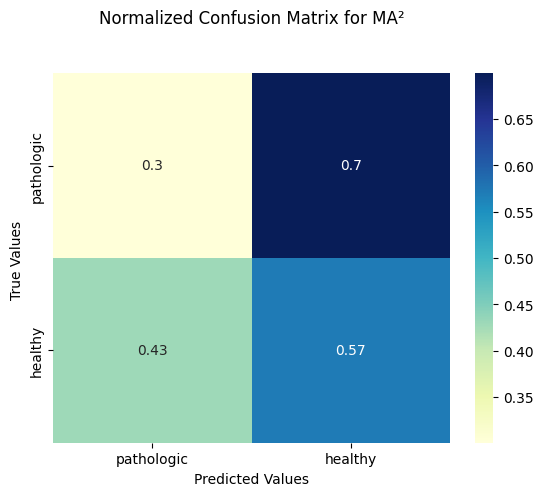

<function matplotlib.pyplot.cla() -> 'None'>

In [77]:
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random

# conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(7)))
# conf_matrix = [conf_matrix[i]*1.0/sum(conf_matrix[i]) for i in range(len(conf_matrix))]

# Using Seaborn heatmap to create the plot
# fx = sebrn.heatmap(conf_matrix, annot=True, cmap="turbo")

# # labels the title and x, y axis of plot
# fx.set_title("Plotting Confusion Matrix using Seaborn\n\n")
# fx.set_xlabel("Predicted Values")
# fx.set_ylabel("Actual Values ")

# # labels the boxes
# fx.xaxis.set_ticklabels(['suprised', 'afraid', 'disgust', 'happy', 'sad', 'angry', 'neutral'])
# fx.yaxis.set_ticklabels(['suprised', 'afraid', 'disgust', 'happy', 'sad', 'angry', 'neutral'])

# atlas.show()

#### 混淆矩阵画图
print ('cm_total:', cm_t)

print ('1:', cm_t[0])
print ('2:', sum(cm_t[0]))

conf_matrix = [cm_t[i]*1.0/sum(cm_t[i]) for i in range(len(cm_t))]

# conf_matrix = cm_total

print ('conf_matrix:', conf_matrix)
fx = sebrn.heatmap(conf_matrix, annot=True, cmap="YlGnBu")
# fx = sebrn.heatmap(cm_t, annot=True, cmap="YlGnBu")

# sn.heatmap(cm_total,annot=True)

fx.set_title("Normalized Confusion Matrix for MA²\n\n")
# fx.set_title("Confusion Matrix for MA²\n\n")
#
fx.set_xlabel("Predicted Values")
fx.set_ylabel("True Values ")

fx.xaxis.set_ticklabels(['pathologic', 'healthy',])
fx.yaxis.set_ticklabels(['pathologic', 'healthy',])
plt.savefig("MA2_con3", dpi=330)
plt.show()

plt.cla


In [ ]:
[[]]

In [ ]:
[[]]

In [ ]:
[[]]

In [ ]:
[[]]

In [ ]:
print (0==False)